<a href="https://colab.research.google.com/github/Raoina/Spectra-2-Image/blob/main/notebooks/image_Transformation/02_GAF_Transformation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!git clone https://github.com/Raoina/Spectra-2-Image

fatal: destination path 'Spectra-2-Image' already exists and is not an empty directory.


# **Si-Ware Dataset**

In [3]:
file_path = '/content/Spectra-2-Image/siware_dataset/split_avg_unique_488/python/spectra_train_488.csv'

In [4]:
import pandas as pd

df = pd.read_csv(file_path)

df.head()

,3921.568654,3935.185205,3948.801765,3962.418316,3976.034876,3989.651427,4003.267987,4016.884537,4030.501097,4044.117648,...,7284.857826,7298.474386,7312.090937,7325.707497,7339.324048,7352.940608,7366.557159,7380.173719,7393.790269,7407.406829
0,7.729080,7.622415,7.546208,7.481664,7.423155,7.377601,7.358989,7.381517,7.454154,7.577913,...,34.616084,35.288379,35.845357,36.327769,36.777222,37.228529,37.695179,38.173677,38.652607,39.125314
1,9.720940,9.584006,9.485654,9.401768,9.326291,9.270802,9.256881,9.306069,9.431605,9.634163,...,42.449703,43.100897,43.648566,44.136925,44.609373,45.097435,45.608556,46.131176,46.646221,47.142563
2,7.551404,7.444440,7.367629,7.300275,7.237015,7.186719,7.165871,7.190576,7.270485,7.406037,...,34.907780,35.560699,36.103651,36.578961,37.026430,37.475247,37.932452,38.389652,38.834516,39.264430
3,6.526686,6.434280,6.366056,6.301643,6.235700,6.175937,6.136361,6.129914,6.163474,6.236180,...,27.640183,28.252847,28.764077,29.212927,29.634762,30.056096,30.485576,30.919745,31.351121,31.777759
4,6.840954,6.757292,6.697071,6.637614,6.573048,6.512227,6.471038,6.464014,6.498781,6.574416,...,28.069196,28.715024,29.254844,29.724470,30.160514,30.594707,31.040131,31.494608,31.948344,32.395361


### normalization -1 ,1 + resampling to 16

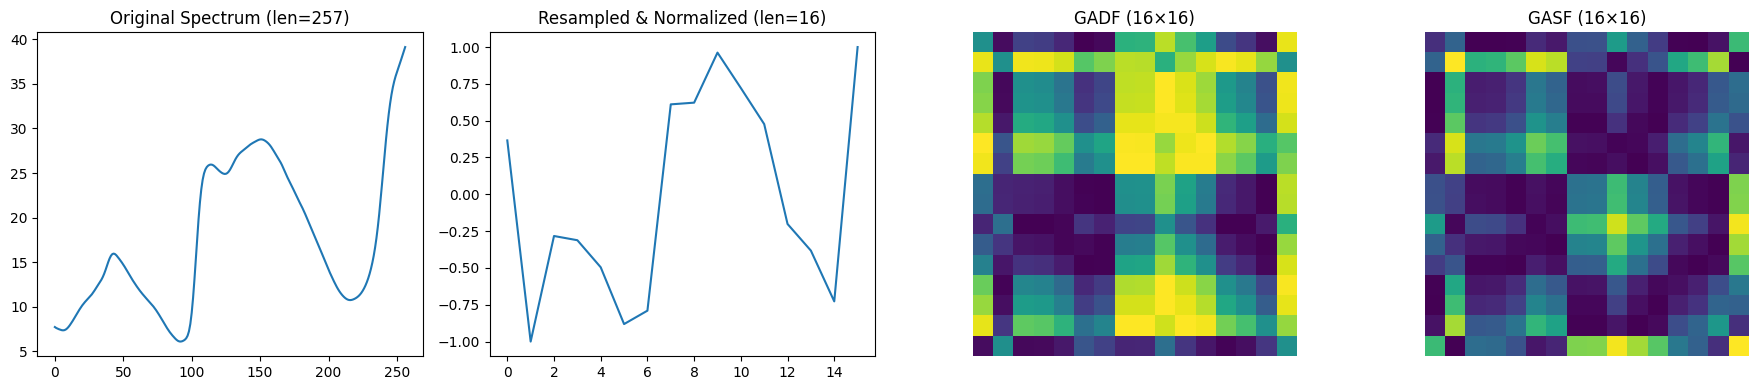

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# ---------- Normalization ----------
def normalize_to_minus1_1(series):
    mn, mx = series.min(), series.max()
    if mx == mn:
        return np.zeros_like(series)
    scaled_01 = (series - mn) / (mx - mn)
    scaled = 2.0 * scaled_01 - 1.0
    return np.clip(scaled, -1.0, 1.0)

# ---------- GADF ----------
def gadf_transform(scaled_series):
    phi = np.arccos(scaled_series)
    phi_sub = np.subtract.outer(phi, phi)
    return np.sin(phi_sub)

# ---------- GASF ----------
def gasf_transform(scaled_series):
    phi = np.arccos(scaled_series)
    phi_add = np.add.outer(phi, phi)
    return np.cos(phi_add)

# -------------------------
target_size = 16

row = df.iloc[0]
spectrum = row.values.astype(float)

# (1) Resample spectrum
resampled = signal.resample(spectrum, target_size)

# (2) Normalize [-1,1]
normed_series = normalize_to_minus1_1(resampled)

# (3) Apply GADF & GASF
gadf = gadf_transform(normed_series)
gasf = gasf_transform(normed_series)

# -------------------------
# Plot
fig, axs = plt.subplots(1, 4, figsize=(18, 4))

axs[0].plot(spectrum)
axs[0].set_title(f"Original Spectrum (len={len(spectrum)})")

axs[1].plot(normed_series)
axs[1].set_title(f"Resampled & Normalized (len={target_size})")

im2 = axs[2].imshow(gadf, cmap="viridis", origin="upper", vmin=-1, vmax=1)
axs[2].set_title(f"GADF ({gadf.shape[0]}×{gadf.shape[1]})")
axs[2].axis("off")

im3 = axs[3].imshow(gasf, cmap="viridis", origin="upper", vmin=-1, vmax=1)
axs[3].set_title(f"GASF ({gasf.shape[0]}×{gasf.shape[1]})")
axs[3].axis("off")

plt.tight_layout()
plt.show()


### GASF + GADF 16*16 with resample

In [6]:
import numpy as np
import os
from matplotlib import cm
from PIL import Image
import gc
from scipy import signal

# -------------------------------
# 1. Setup output directories
# -------------------------------
gasf_dir = "/content/drive/MyDrive/GASF_16_resamp_norm-1"
gadf_dir = "/content/drive/MyDrive/GADF_16_resamp_norm-1"
os.makedirs(gasf_dir, exist_ok=True)
os.makedirs(gadf_dir, exist_ok=True)

# -------------------------------
# 2. Normalization [-1,1]
# -------------------------------
def normalize_to_minus1_1(series):
    mn, mx = series.min(), series.max()
    if mx == mn:
        return np.zeros_like(series)
    scaled_01 = (series - mn) / (mx - mn)
    scaled = 2.0 * scaled_01 - 1.0
    return np.clip(scaled, -1.0, 1.0)

# -------------------------------
# 3. GADF & GASF (same logic as single-sample version)
# -------------------------------
def gadf_transform(scaled_series):
    phi = np.arccos(scaled_series)
    phi_sub = np.subtract.outer(phi, phi)
    return np.sin(phi_sub)

def gasf_transform(scaled_series):
    phi = np.arccos(scaled_series)
    phi_add = np.add.outer(phi, phi)
    return np.cos(phi_add)

# -------------------------------
# 4. Save matrix as image
# -------------------------------
def save_matrix(mat, path):
    arr = (mat + 1) / 2  # scale [-1,1] → [0,1]
    rgba = cm.viridis(arr)
    rgb = (rgba[:, :, :3] * 255).astype(np.uint8)
    Image.fromarray(rgb).save(path)

# -------------------------------
# 5. Batch processing settings
# -------------------------------
target_size = 16        # same as small code
batch_size = 100
num_samples = len(df)

# -------------------------------
# 6. Process dataset
# -------------------------------
for batch_start in range(0, num_samples, batch_size):
    batch_end = min(batch_start + batch_size, num_samples)
    print(f"Processing batch {batch_start} .. {batch_end-1}")

    for idx in range(batch_start, batch_end):
        gasf_path = os.path.join(gasf_dir, f"RESAMP_{idx}.png")
        gadf_path = os.path.join(gadf_dir, f"RESAMP_{idx}.png")

        if os.path.exists(gasf_path) and os.path.exists(gadf_path):
            continue

        # Step 1: Load spectrum
        spectrum = df.iloc[idx].values.astype(float)

        # Step 2: Resample (e.g., 257 → 16)
        resampled = signal.resample(spectrum, target_size)

        # Step 3: Normalize [-1,1]
        normed_series = normalize_to_minus1_1(resampled)

        # Step 4: Compute GADF / GASF
        gadf = gadf_transform(normed_series)
        gasf = gasf_transform(normed_series)

        # Step 5: Save
        save_matrix(gadf, gadf_path)
        save_matrix(gasf, gasf_path)

        del resampled, normed_series, gadf, gasf
        gc.collect()

    print(f"Batch {batch_start} to {batch_end-1} done ✅")


Processing batch 0 .. 99
Batch 0 to 99 done ✅
Processing batch 100 .. 199
Batch 100 to 199 done ✅
Processing batch 200 .. 299
Batch 200 to 299 done ✅
Processing batch 300 .. 399
Batch 300 to 399 done ✅
Processing batch 400 .. 487
Batch 400 to 487 done ✅


In [10]:
import numpy as np
import os
from matplotlib import cm
from PIL import Image
import gc

# -------------------------------
# 1. Setup output directories
# -------------------------------
gasf_dir = "/content/drive/MyDrive/GASF_PAA16_norm-1"
gadf_dir = "/content/drive/MyDrive/GADF_PAA16_norm-1"
os.makedirs(gasf_dir, exist_ok=True)
os.makedirs(gadf_dir, exist_ok=True)

# -------------------------------
# 2. Normalization [-1,1]
# -------------------------------
def normalize_to_minus1_1(series):
    mn, mx = series.min(), series.max()
    if mx == mn:
        return np.zeros_like(series)
    scaled_01 = (series - mn) / (mx - mn)
    scaled = 2.0 * scaled_01 - 1.0
    return np.clip(scaled, -1.0, 1.0)

# -------------------------------
# 3. PAA (Piecewise Aggregate Approximation)
# -------------------------------
def paa(series, segments):
    n = len(series)
    base = n // segments
    rem = n % segments
    res = []
    idx = 0
    for i in range(segments):
        seg_len = base + (1 if i < rem else 0)
        seg = series[idx: idx + seg_len]
        res.append(seg.mean())
        idx += seg_len
    return np.array(res)

# -------------------------------
# 4. GADF & GASF
# -------------------------------
def gadf_transform(scaled_series):
    phi = np.arccos(scaled_series)
    phi_sub = np.subtract.outer(phi, phi)
    return np.sin(phi_sub)

def gasf_transform(scaled_series):
    phi = np.arccos(scaled_series)
    phi_add = np.add.outer(phi, phi)
    return np.cos(phi_add)

# -------------------------------
# 5. Save matrix as image
# -------------------------------
def save_matrix(mat, path):
    arr = (mat + 1) / 2  # scale [-1,1] → [0,1]
    rgba = cm.viridis(arr)
    rgb = (rgba[:, :, :3] * 255).astype(np.uint8)
    Image.fromarray(rgb).save(path)

# -------------------------------
# 6. Settings
# -------------------------------
paa_segments = 16
batch_size = 100
num_samples = len(df)

# -------------------------------
# 7. Process dataset
# -------------------------------
for batch_start in range(0, num_samples, batch_size):
    batch_end = min(batch_start + batch_size, num_samples)
    print(f"Processing batch {batch_start} .. {batch_end-1}")

    for idx in range(batch_start, batch_end):
        gasf_path = os.path.join(gasf_dir, f"PAA16_{idx}.png")
        gadf_path = os.path.join(gadf_dir, f"PAA16_{idx}.png")

        if os.path.exists(gasf_path) and os.path.exists(gadf_path):
            continue

        # Step 1: Load spectrum
        spectrum = df.iloc[idx].values.astype(float)

        # Step 2: Apply PAA to 128 segments
        paa_series = paa(spectrum, paa_segments)

        # Step 3: Normalize [-1,1]
        normed_series = normalize_to_minus1_1(paa_series)

        # Step 4: GADF & GASF
        gadf = gadf_transform(normed_series)
        gasf = gasf_transform(normed_series)

        # Step 5: Save
        save_matrix(gadf, gadf_path)
        save_matrix(gasf, gasf_path)

        del paa_series, normed_series, gadf, gasf
        gc.collect()

    print(f"Batch {batch_start} to {batch_end-1} done ✅")


Processing batch 0 .. 99
Batch 0 to 99 done ✅
Processing batch 100 .. 199
Batch 100 to 199 done ✅
Processing batch 200 .. 299
Batch 200 to 299 done ✅
Processing batch 300 .. 399
Batch 300 to 399 done ✅
Processing batch 400 .. 487
Batch 400 to 487 done ✅


In [ ]:
import shutil
from google.colab import files

# ---------- Compress folders ----------
shutil.make_archive("GADF_PAA16_norm-1", 'zip', "GADF_PAA16_norm-1")
shutil.make_archive("GASF_PAA16_norm-1", 'zip', "GASF_PAA16_norm-1")
shutil.make_archive("GADF_16_resamp_norm-1", 'zip', "GADF_16_resamp_norm-1")
shutil.make_archive("GASF_16_resamp_norm-1", 'zip', "GASF_16_resamp_norm-1")

# ---------- Download ----------
files.download("GADF_PAA16_norm-1.zip")
files.download("GASF_PAA16_norm-1.zip")
files.download("GADF_16_resamp_norm-1.zip")
files.download("GASF_16_resamp_norm-1.zip")

# **LUCAS Dataset**

In [ ]:
file_path = '/content/drive/MyDrive/LUCAS.SOIL_corr.csv'

In [ ]:
import pandas as pd

df = pd.read_csv(file_path)

df.head()

/tmp/ipython-input-3672932280.py:3: DtypeWarning: Columns (1,2,4216,4231,4234,4237,4274) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


,Unnamed: 0,sample.ID,ID,date,spc.400,spc.400.5,spc.401,spc.401.5,spc.402,spc.402.5,...,WRBLV1,WRBADJ1,PARMADO1,PARMADO2,PARMADO3,PARMASE1,PARMASE2,PARMASE3,MIN_TOP,mineral
0,4,100,100,2011-01-24 16:02:25,0.831705,0.839111,0.846473,0.853773,0.860988,0.868098,...,CM,dy,3.0,31.0,310.0,5.0,56.0,561.0,KQ,mineral
1,5,1000,1000,2010-09-30 14:50:01,0.706027,0.714901,0.723727,0.732480,0.741142,0.749684,...,CM,dy,3.0,31.0,311.0,3.0,31.0,310.0,KQ,mineral
2,6,10000,10000,2010-10-19 12:06:16,0.666238,0.676472,0.686654,0.696757,0.706753,0.716615,...,CM,ca,2.0,21.0,214.0,0.0,0.0,0.0,MS,mineral
3,7,10001,10001,2010-10-19 15:00:01,0.698136,0.706548,0.714909,0.723197,0.731384,0.739448,...,CM,dy,3.0,31.0,310.0,4.0,42.0,420.0,KQ,mineral
4,8,10002,10002,2011-04-30 12:26:27,0.675433,0.684820,0.694163,0.703438,0.712620,0.721693,...,LV,ha,7.0,71.0,710.0,6.0,62.0,620.0,M,mineral


# **Sample Review**

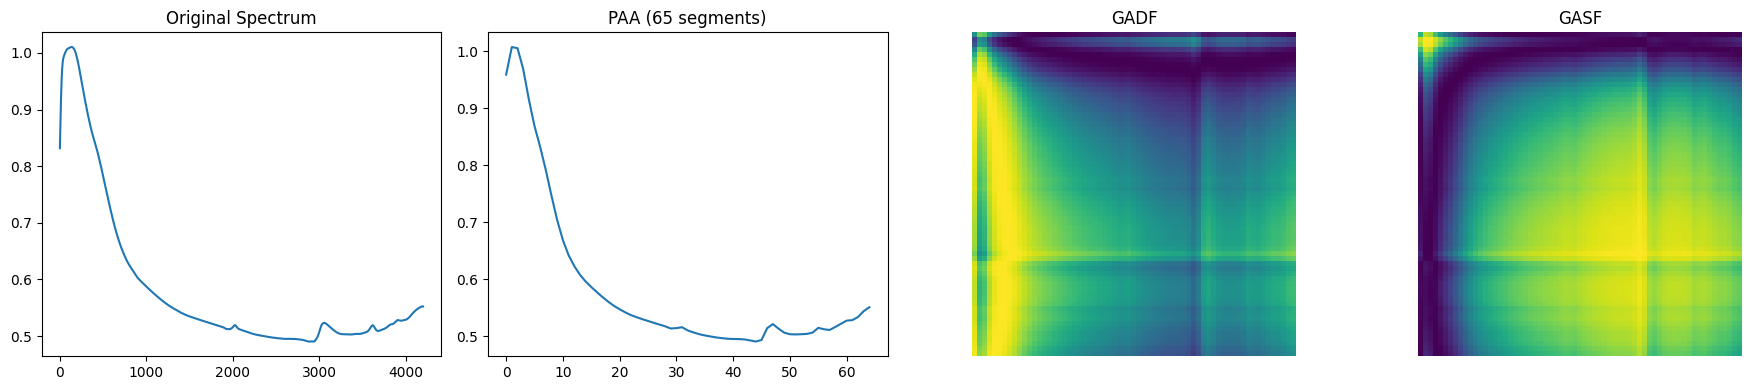

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def paa_distribute(series, segments):
    n = len(series)
    base = n // segments
    rem = n % segments
    res = []
    idx = 0
    for i in range(segments):
        seg_len = base + (1 if i < rem else 0)
        seg = series[idx: idx+seg_len]
        res.append(seg.mean())
        idx += seg_len
    return np.array(res)

# ---------- GADF ----------
def gadf_transform(paa_series):
    # 1️⃣ Normalize to [0,1]
    mn, mx = paa_series.min(), paa_series.max()
    if mx == mn:
        scaled_01 = np.zeros_like(paa_series)
    else:
        scaled_01 = (paa_series - mn) / (mx - mn)

    # 2️⃣ Convert to [-1,1]
    scaled = 2.0 * scaled_01 - 1.0
    scaled = np.clip(scaled, -1.0, 1.0)

    # 3️⃣ Compute angles and GADF
    phi = np.arccos(scaled)
    phi_sub = np.subtract.outer(phi, phi)
    GADF = np.sin(phi_sub)
    return GADF

# ---------- GASF ----------
def gasf_transform(paa_series):
    # 1️⃣ Normalize to [0,1]
    mn, mx = paa_series.min(), paa_series.max()
    if mx == mn:
        scaled_01 = np.zeros_like(paa_series)
    else:
        scaled_01 = (paa_series - mn) / (mx - mn)

    # 2️⃣ Convert to [-1,1]
    scaled = 2.0 * scaled_01 - 1.0
    scaled = np.clip(scaled, -1.0, 1.0)

    # 3️⃣ Compute angles and GASF
    phi = np.arccos(scaled)
    phi_add = np.add.outer(phi, phi)
    GASF = np.cos(phi_add)
    return GASF

segments = 65

row = df.iloc[0]
spectrum = row.filter(like="spc.").values.astype(float)

# PAA
paa_series = paa_distribute(spectrum, segments)

# GADF و GASF
gadf = gadf_transform(paa_series)
gasf = gasf_transform(paa_series)

fig, axs = plt.subplots(1, 4, figsize=(18, 4))

axs[0].plot(spectrum)
axs[0].set_title("Original Spectrum")

axs[1].plot(paa_series)
axs[1].set_title(f"PAA ({segments} segments)")

# GADF
im2 = axs[2].imshow(gadf, cmap="viridis", origin="upper", vmin=-1, vmax=1)
axs[2].set_title("GADF")
axs[2].axis("off")

# GASF
im3 = axs[3].imshow(gasf, cmap="viridis", origin="upper", vmin=-1, vmax=1)
axs[3].set_title("GASF")
axs[3].axis("off")

plt.tight_layout()
plt.show()

# **Sample Review with polar plot**

In [ ]:
!pip install pyts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 35.4 MB/s eta 0:00:00


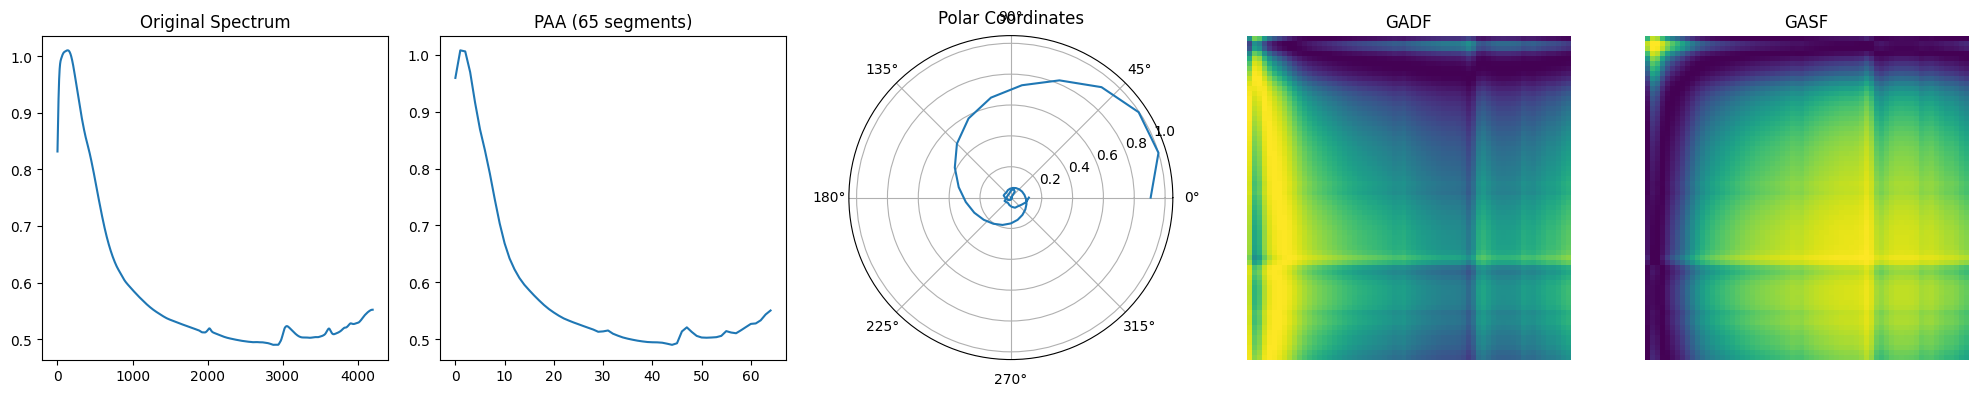

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def paa_distribute(series, segments):
    n = len(series)
    base = n // segments
    rem = n % segments
    res = []
    idx = 0
    for i in range(segments):
        seg_len = base + (1 if i < rem else 0)
        seg = series[idx: idx+seg_len]
        res.append(seg.mean())
        idx += seg_len
    return np.array(res)

# ---------- GADF ----------
def gadf_transform(paa_series):
    mn, mx = paa_series.min(), paa_series.max()
    if mx == mn:
        scaled = np.zeros_like(paa_series)
    else:
        scaled = 2.0 * (paa_series - mn) / (mx - mn) - 1.0
    scaled = np.clip(scaled, -1.0, 1.0)
    phi = np.arccos(scaled)
    phi_sub = np.subtract.outer(phi, phi)
    GADF = np.sin(phi_sub)
    return GADF

# ---------- GASF ----------
def gasf_transform(paa_series):
    mn, mx = paa_series.min(), paa_series.max()
    if mx == mn:
        scaled = np.zeros_like(paa_series)
    else:
        scaled = 2.0 * (paa_series - mn) / (mx - mn) - 1.0
    scaled = np.clip(scaled, -1.0, 1.0)
    phi = np.arccos(scaled)
    phi_add = np.add.outer(phi, phi)
    GASF = np.cos(phi_add)
    return GASF

# ---------- إعداد ----------
segments = 65

# أول sample
row = df.iloc[0]
spectrum = row.filter(like="spc.").values.astype(float)

# PAA
paa_series = paa_distribute(spectrum, segments)

# Normalize PAA for polar plot
scaled_paa = (paa_series - paa_series.min()) / (paa_series.max() - paa_series.min())

# GADF و GASF
gadf = gadf_transform(paa_series)
gasf = gasf_transform(paa_series)

fig = plt.figure(figsize=(20, 4))

ax0 = fig.add_subplot(1, 5, 1)
ax0.plot(spectrum)
ax0.set_title("Original Spectrum")

ax1 = fig.add_subplot(1, 5, 2)
ax1.plot(paa_series)
ax1.set_title(f"PAA ({segments} segments)")

# 3. Polar Plot (Spiral Style)
theta = np.linspace(0, 6 * np.pi, len(scaled_paa))  # spiral loops
r = scaled_paa
ax2 = fig.add_subplot(1, 5, 3, projection='polar')
ax2.plot(theta, r)
ax2.set_title("Polar Coordinates", va='bottom')
ax2.grid(True)

# 4. GADF
ax3 = fig.add_subplot(1, 5, 4)
ax3.imshow(gadf, cmap="viridis", origin="upper", vmin=-1, vmax=1)
ax3.set_title("GADF")
ax3.axis("off")

# 5. GASF
ax4 = fig.add_subplot(1, 5, 5)
ax4.imshow(gasf, cmap="viridis", origin="upper", vmin=-1, vmax=1)
ax4.set_title("GASF")
ax4.axis("off")

plt.tight_layout()
plt.show()

#**GASF**

In [ ]:
import numpy as np
import os
from matplotlib import cm
from PIL import Image
import gc

# -------------------------------
# 1. Setup output directory
# -------------------------------
gasf_dir = "GASF_images"
os.makedirs(gasf_dir, exist_ok=True)

# -------------------------------
# 2. PAA - Piecewise Aggregate Approximation
# This reduces the length of the spectral sequence while
# preserving its main trends. The remainder (if the series
# cannot be divided exactly) is distributed across the first
# few segments.
# -------------------------------
def paa_distribute(series, segments):
    n = len(series)
    base = n // segments
    rem = n % segments
    res = []
    idx = 0
    for i in range(segments):
        seg_len = base + (1 if i < rem else 0)
        seg = series[idx: idx + seg_len]
        res.append(seg.mean())
        idx += seg_len
    return np.array(res)

# -------------------------------
# 3. GASF Transform
# Steps based on the paper:
#  a) Normalize PAA series to [0,1] first (for consistency across samples)
#  b) Convert normalized series to [-1,1] before arccos
#  c) Compute phi = arccos(scaled)
#  d) Compute GASF = cos(phi_i + phi_j)
# -------------------------------
def gasf_transform(paa_series):
    # Step a: normalize to [0,1]
    mn, mx = paa_series.min(), paa_series.max()
    if mx == mn:
        norm_01 = np.zeros_like(paa_series)
    else:
        norm_01 = (paa_series - mn) / (mx - mn)

    # Step b: convert to [-1,1] for arccos
    scaled = norm_01 * 2.0 - 1.0
    scaled = np.clip(scaled, -1, 1)  # ensure valid range for arccos

    # Step c: compute polar angles
    phi = np.arccos(scaled)

    # Step d: compute GASF matrix
    phi_sum = np.add.outer(phi, phi)
    gasf = np.cos(phi_sum)
    return gasf

# -------------------------------
# 4. Save matrix as image
# Values in GASF are in [-1,1], we scale to [0,1] for image
# colormap 'viridis' is applied for visualization
# -------------------------------
def save_matrix(mat, path):
    arr = (mat + 1) / 2  # scale [-1,1] → [0,1]
    rgba = cm.viridis(arr)
    rgb = (rgba[:, :, :3] * 255).astype(np.uint8)
    Image.fromarray(rgb).save(path)

# -------------------------------
# 5. Batch processing settings
# -------------------------------
segments = 65          # number of PAA segments
batch_size = 200       # number of samples per batch
num_samples = len(df)  # total number of spectra

# -------------------------------
# 6. Process dataset batch by batch
# -------------------------------
for batch_start in range(0, num_samples, batch_size):
    batch_end = min(batch_start + batch_size, num_samples)
    print(f"Processing GASF batch {batch_start} .. {batch_end-1}")

    for idx in range(batch_start, batch_end):
        gasf_path = os.path.join(gasf_dir, f"sample_{idx}.png")
        if os.path.exists(gasf_path):
            continue  # skip if already processed

        # Load spectral data
        spectrum = df.iloc[idx].filter(like="spc.").values.astype(float)

        # Step 2: Apply PAA
        paa_series = paa_distribute(spectrum, segments)

        # Step 3: Compute GASF
        gasf = gasf_transform(paa_series)

        # Step 4: Save GASF as image
        save_matrix(gasf, gasf_path)

        # Free memory
        del paa_series, gasf
        gc.collect()

    print(f"GASF batch {batch_start} to {batch_end-1} done ✅")

Processing GASF batch 0 .. 199
GASF batch 0 to 199 done ✅
Processing GASF batch 200 .. 399
GASF batch 200 to 399 done ✅
Processing GASF batch 400 .. 599
GASF batch 400 to 599 done ✅
Processing GASF batch 600 .. 799
GASF batch 600 to 799 done ✅
Processing GASF batch 800 .. 999
GASF batch 800 to 999 done ✅
Processing GASF batch 1000 .. 1199
GASF batch 1000 to 1199 done ✅
Processing GASF batch 1200 .. 1399
GASF batch 1200 to 1399 done ✅
Processing GASF batch 1400 .. 1599
GASF batch 1400 to 1599 done ✅
Processing GASF batch 1600 .. 1799
GASF batch 1600 to 1799 done ✅
Processing GASF batch 1800 .. 1999
GASF batch 1800 to 1999 done ✅
Processing GASF batch 2000 .. 2199
GASF batch 2000 to 2199 done ✅
Processing GASF batch 2200 .. 2399
GASF batch 2200 to 2399 done ✅
Processing GASF batch 2400 .. 2599
GASF batch 2400 to 2599 done ✅
Processing GASF batch 2600 .. 2799
GASF batch 2600 to 2799 done ✅
Processing GASF batch 2800 .. 2999
GASF batch 2800 to 2999 done ✅
Processing GASF batch 3000 .. 3199

# **GADF**

In [ ]:
gadf_dir = "GADF_images"
os.makedirs(gadf_dir, exist_ok=True)

def paa_distribute(series, segments):
    n = len(series)
    base = n // segments
    rem = n % segments
    res = []
    idx = 0
    for i in range(segments):
        seg_len = base + (1 if i < rem else 0)
        seg = series[idx: idx+seg_len]
        res.append(seg.mean())
        idx += seg_len
    return np.array(res)

# ------ GADF ------
def gadf_transform(paa_series):
    mn, mx = paa_series.min(), paa_series.max()
    if mx == mn:
        scaled = np.zeros_like(paa_series)
    else:
        scaled = 2.0 * (paa_series - mn) / (mx - mn) - 1.0
    scaled = np.clip(scaled, -1, 1)
    phi = np.arccos(scaled)
    phi_sub = np.subtract.outer(phi, phi)
    return np.sin(phi_sub)

def save_matrix(mat, path):
    arr = (mat + 1) / 2  # normalize to 0-1 for image
    rgba = cm.viridis(arr)
    rgb = (rgba[:, :, :3] * 255).astype(np.uint8)
    Image.fromarray(rgb).save(path)

segments = 65
batch_size = 500
num_samples = len(df)

for batch_start in range(0, num_samples, batch_size):
    batch_end = min(batch_start + batch_size, num_samples)
    print(f"Processing GADF batch {batch_start} .. {batch_end-1}")
    for idx in range(batch_start, batch_end):
        gadf_path = os.path.join(gadf_dir, f"sample_{idx}.png")
        if os.path.exists(gadf_path):
            continue
        spectrum = df.iloc[idx].filter(like="spc.").values.astype(float)
        paa_series = paa_distribute(spectrum, segments)
        gadf = gadf_transform(paa_series)
        save_matrix(gadf, gadf_path)
        del paa_series, gadf
        gc.collect()
    print(f"GADF batch {batch_start} to {batch_end-1} done ✅")


Processing GADF batch 0 .. 499
GADF batch 0 to 499 done ✅
Processing GADF batch 500 .. 999
GADF batch 500 to 999 done ✅
Processing GADF batch 1000 .. 1499
GADF batch 1000 to 1499 done ✅
Processing GADF batch 1500 .. 1999
GADF batch 1500 to 1999 done ✅
Processing GADF batch 2000 .. 2499
GADF batch 2000 to 2499 done ✅
Processing GADF batch 2500 .. 2999
GADF batch 2500 to 2999 done ✅
Processing GADF batch 3000 .. 3499
GADF batch 3000 to 3499 done ✅
Processing GADF batch 3500 .. 3999
GADF batch 3500 to 3999 done ✅
Processing GADF batch 4000 .. 4499
GADF batch 4000 to 4499 done ✅
Processing GADF batch 4500 .. 4999
GADF batch 4500 to 4999 done ✅
Processing GADF batch 5000 .. 5499
GADF batch 5000 to 5499 done ✅
Processing GADF batch 5500 .. 5999
GADF batch 5500 to 5999 done ✅
Processing GADF batch 6000 .. 6499
GADF batch 6000 to 6499 done ✅
Processing GADF batch 6500 .. 6999
GADF batch 6500 to 6999 done ✅
Processing GADF batch 7000 .. 7499
GADF batch 7000 to 7499 done ✅
Processing GADF batch 

In [ ]:
import shutil
from google.colab import files

# ---------- Compress folders ----------
shutil.make_archive("GASF_images", 'zip', "GASF_images")
shutil.make_archive("GADF_images", 'zip', "GADF_images")

# ---------- Download ----------
files.download("GASF_images.zip")
files.download("GADF_images.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>